In [1]:
import matplotlib.pyplot as plt
import time

import autograd.numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian

In [2]:
verbo = False
def plota_linha(ponto_inicial,ponto_final):
    if(verbo == False):
        return

    pontos = np.array([ponto_inicial,ponto_final])

    plt.plot(pontos[:,0],pontos[:,1],c = "black")
    return

def plota_curvas(funcao,alpha = 0.01):
    if(verbo == False):
        return

    xl = plt.xlim()
    yl = plt.ylim()

    x = np.arange(xl[0]-1,xl[1]+1,alpha)
    y = np.arange(yl[0]-1,yl[1]+1,alpha)

    xv,yv = np.meshgrid(x,y)

    fv = f([xv,yv])
    cv = np.any(c([xv,yv]) > 0, axis = 0)
    fv[cv] = np.nan

    fv = np.log(fv + np.abs(np.nanmin(fv)) + 10)
    plt.contourf(xv,yv,fv,20,cmap="Spectral")
    plt.show()
    plt.clf()
    return

def plota_curvas_dom(funcao,x,y,alpha = 0.01):
    if(verbo == False):
        return


    x = np.arange(x[0],x[1],alpha)
    y = np.arange(y[0]-1,y[1],alpha)

    xv,yv = np.meshgrid(x,y)

    fv = f([xv,yv])
    cv = np.any(c([xv,yv]) > 0, axis = 0)
    fv[cv] = np.nan

    fmin = np.nanmin(fv)
    fmin_idx = np.unravel_index(np.nanargmin(fv),fv.shape)
    print(fmin_idx,x[fmin_idx[1]],y[fmin_idx[0]])

    fv = np.log(fv + np.abs(fmin) + 10)

    plt.contourf(xv,yv,fv,20,cmap="Spectral")
    plt.scatter(x[fmin_idx[1]],y[fmin_idx[0]],marker = "+", c = "k")
    plt.show()
    plt.clf()
    return

## Metodos de busca linear

In [3]:
alpha_linear = 0.01
barreira = lambda x: np.array([1,1])
def passo_constante(ponto_inicial,direcao,funcao):
    if(sum(abs(direcao))==0):
        return ponto_inicial, direcao

    valor_inicial = funcao(ponto_inicial)
    direcao = direcao/(direcao@direcao)**(1/2)

    valor_final = funcao(ponto_inicial + direcao*alpha_linear)

    if(valor_inicial < valor_final):
        direcao = -direcao
        valor_final = funcao(ponto_inicial + direcao*alpha_linear)

    ponto_final = ponto_inicial
    while valor_inicial >= valor_final:
        valor_inicial = valor_final
        ponto_final = ponto_inicial + direcao*alpha_linear
        if(any(barreira(ponto_final) <0)):
            direcao = 0
            break
        ponto_inicial = ponto_final
        valor_final = funcao(ponto_inicial)

    return ponto_inicial, direcao*alpha_linear

def bisseccao(ponto_inicial,ponto_final,funcao):
    valor_inicial = funcao(ponto_inicial)
    valor_final = funcao(ponto_final)

    while abs(valor_inicial - valor_final) > tol_linear:
        ponto_medio = (ponto_inicial+ponto_final)/2
        valor_medio = funcao(ponto_medio)

        if(valor_inicial > valor_final):
            ponto_inicial = ponto_medio
            valor_inicial = valor_medio

        else:
            ponto_final = ponto_medio
            valor_final = valor_medio

    return (ponto_inicial+ponto_final)/2

def seccao_aurea(ponto_inicial,ponto_final,funcao):
    valor_inicial = funcao(ponto_inicial)
    valor_final = funcao(ponto_final)

    ra = (5**(1/2)-1)/2
    while sum(abs(ponto_inicial-ponto_final)) > tol_linear:
        ponto_a = ponto_inicial*ra + (1-ra)*ponto_final
        valor_a = funcao(ponto_a)

        ponto_b = ponto_inicial*(1-ra) + ra*ponto_final
        valor_b = funcao(ponto_b)

        if(valor_a < valor_b):
            ponto_final = ponto_b
            valor_final = valor_b
        else:
            ponto_inicial = ponto_a
            valor_inicial = valor_a

    return (ponto_inicial+ponto_final)/2


## Metodos de busca de direção

In [4]:
tol_grad = 1e-5
tol_valor = 1e-5
tol_dist = 1e-5
tol_linear = 1e-5
tol_ocr = 1e-5
max_passos = 100

### Ordem 0


In [5]:
def univariante(ponto,funcao):
    fgrad = egrad(funcao)
    valor = funcao(ponto)

    dim = len(ponto)
    direcao = np.eye(dim)
    k = 0
    a = 0;
    while True:
        valor_anterior = valor
        for i in range(dim):
            ponto_anterior = ponto
            ponto, intervalo = passo_constante(ponto,direcao[i,:],funcao)
            ponto = seccao_aurea(ponto-intervalo, ponto+intervalo,funcao)

            k = k+1;
            plota_linha(ponto_anterior,ponto)
        valor = funcao(ponto)

        if(k > max_passos):
            print("Metodo univariante atingiu o máximo de passos")
            break

        if(sum(abs(fgrad(ponto))) < tol_grad):
            break

        if(abs(valor-valor_anterior) < tol_valor):
            break
    return ponto,k

In [6]:
def powell(ponto,funcao):
    fgrad = egrad(funcao)
    valor = funcao(ponto)
    valor_anterior = valor

    dim = len(ponto)
    direcao = np.eye(dim)

    j = 0;
    k = 0;
    ponto_prox = ponto
    while True:
        if(j > dim):
            direcao = np.eye(dim)
            j = 0

        for i in range(dim):
            ponto_anterior = ponto_prox
            ponto_prox, intervalo = passo_constante(ponto_prox,direcao[i,:],funcao)
            ponto_prox = seccao_aurea(ponto_prox-intervalo, ponto_prox+intervalo,funcao)
            k = k+1;
            plota_linha(ponto_anterior,ponto_prox)

        for i in range(dim-1):
            direcao[i,:] = direcao[i+1,:]

        direcao[dim-1,:] = ponto_prox - ponto
        ponto_anterior = ponto_prox
        valor_anterior = funcao(ponto_prox)
        ponto_prox, intervalo = passo_constante(ponto_prox,direcao[dim-1,:],funcao)
        ponto_prox = seccao_aurea(ponto_prox-intervalo, ponto_prox+intervalo,funcao)
        valor = funcao(ponto_prox)

        plota_linha(ponto_anterior,ponto_prox)
        k = k+1
        j = j + 1

        ponto = ponto_prox
        if(k > max_passos):
            print("Metodo de powell atingiu o máximo de passos")
            break

        if(sum(abs(fgrad(ponto))) < tol_grad):
            break

        if(abs(valor-valor_anterior) < tol_valor):
            break
    return ponto,k

### Ordem 1

In [7]:
def steepest_descent(ponto,funcao):
    fgrad = egrad(funcao)

    valor_anterior = funcao(ponto)

    direcao = -fgrad(ponto)
    k=0
    while True:
        ponto_anterior = ponto
        ponto, intervalo = passo_constante(ponto,direcao,funcao)
        ponto = seccao_aurea(ponto-intervalo, ponto+intervalo,funcao)
        plota_linha(ponto_anterior,ponto)
        k = k+1

        direcao = -fgrad(ponto)

        if(k > max_passos):
            print("Steepest descent atingiu o máximo de passos")
            break

        if(sum(abs(fgrad(ponto))) < tol_grad):
            break

        valor = funcao(ponto)
        if(abs(valor-valor_anterior) < tol_valor):
            break
        valor_anterior = valor
    return ponto,k

In [8]:
def fletcher_reeves(ponto,funcao):
    fgrad = egrad(funcao)

    valor_anterior = funcao(ponto)

    grad_anterior = fgrad(ponto)
    direcao = -grad_anterior
    k = 0;
    while True:
        ponto_anterior = ponto
        ponto, intervalo = passo_constante(ponto,direcao,funcao)
        ponto = seccao_aurea(ponto-intervalo, ponto+intervalo,funcao)
        plota_linha(ponto_anterior,ponto)
        k = k+1;

        grad_atual = fgrad(ponto)
        beta = (grad_atual@grad_atual)/(grad_anterior@grad_anterior)

        direcao = -grad_atual + beta*direcao

        grad_anterior = grad_atual

        if(k > max_passos):
            print("Fletcher-Reeves atingiu o máximo de passos")
            break

        if(sum(abs(fgrad(ponto))) < tol_grad):
            break

        valor = funcao(ponto)
        if(abs(valor-valor_anterior) < tol_valor):
            break
        valor_anterior = valor
    return ponto,k

###Ordem 2



In [9]:
def bfgs(ponto,funcao):
    S = np.eye(ponto.shape[0])
    fgrad = egrad(funcao)

    grad_anterior = fgrad(ponto)
    direcao = -S@grad_anterior
    k=0
    while True:
        ponto_proximo, intervalo = passo_constante(ponto,direcao,funcao)
        ponto_proximo = seccao_aurea(ponto_proximo-intervalo, ponto+intervalo,funcao)
        plota_linha(ponto,ponto_proximo)
        k = k+1
        grad_atual = fgrad(ponto_proximo)

        if(k > max_passos):
            print("BFGS atingiu o máximo de passos")
            break

        if(sum(abs(fgrad(ponto))) < tol_grad):
            break

        if(sum(abs(ponto-ponto_proximo)) < tol_dist):
            break

        delta_x = ponto_proximo - ponto
        delta_x = np.reshape(delta_x,[1,delta_x.shape[0]])

        ponto = ponto_proximo

        delta_g = grad_atual - grad_anterior
        delta_g = np.reshape(delta_g,[1,delta_g.shape[0]])

        grad_anterior = grad_atual
        S = S + ((delta_x@delta_g.T+ delta_g@S@delta_g.T)*(delta_x.T@delta_x))/(delta_x@delta_g.T)**2 - (S@delta_g.T@delta_x+delta_x.T@delta_g@S.T)/(delta_x@delta_g.T)

        direcao = -S@grad_atual

    return ponto,k

In [10]:
def newton_raphson(ponto,funcao):
    fgrad = egrad(funcao)
    H_f = jacobian(fgrad)

    valor_anterior = funcao(ponto)

    k=0
    while True:
        direcao = -np.linalg.inv(H_f(ponto))@fgrad(ponto)
        ponto_anterior = ponto
        ponto, intervalo = passo_constante(ponto,direcao,funcao)
        ponto = seccao_aurea(ponto-intervalo, ponto+intervalo,funcao)
        plota_linha(ponto_anterior,ponto)
        k = k+1

        if(k > max_passos):
            print("Newton-Raphson atingiu o máximo de passos")
            break

        if(sum(abs(fgrad(ponto))) < tol_grad):
            break

        valor = funcao(ponto)
        if(abs(valor-valor_anterior) < tol_valor):
            break
        valor_anterior = valor

    return ponto,k

# Metodos de OCR

In [11]:
def ocr_penalidade(f,h,c,x,metodo,rp=1,beta_p=10):
    k = 0
    t = 0

    start_time = time.time()
    while(True):
        k = k+1
        penalidade = lambda x:rp/2*np.sum(h(x)**2)+rp/2*np.sum(np.maximum(0,c(x))**2)
        phi = lambda x:f(x)+penalidade(x)

        x_anterior = x
        x,l = metodo(x,phi)
        t = t+l

        #print(penalidade(x),np.sum(abs(x - x_anterior)),tol_ocr)
        if(np.sum(abs(x - x_anterior)) < tol_ocr and penalidade(x) < tol_ocr):
            break
        if(k>max_passos):
            break

        rp = rp*beta_p

    end_time = time.time()
    print("Numero total de chamadas ao metodo OSR", k)
    print("Numero total de passos dos metodos OSR", t)
    print("Ponto de minimo encontrado",x)
    print("Tempo de execução:",end_time-start_time)
    plota_curvas(f)
    return x

In [12]:
def ocr_barreira(f,h,c,x,metodo,rp = 1,beta_p = 1,rb = 10,beta_b = 1/10):
    global barreira
    k = 0
    t = 0

    start_time = time.time()
    while(True):
        k = k+1
        barreira = lambda x: -rb/c(x)
        penalidade = lambda x: rp/2*np.sum(h(x)**2) + np.sum(barreira(x))
        phi = lambda x:f(x)+penalidade(x)

        x_anterior = x;
        x,l = metodo(x,phi)
        t = t+l

        #print(penalidade(x),np.sum(abs(x - x_anterior)),tol_ocr)
        if(np.sum(abs(x - x_anterior)) < tol_ocr and penalidade(x) < tol_ocr):
            break
        if(k>max_passos):
            break

        if(penalidade(x) > 0 ):
            rp = rp*beta_p
            rb = rb*beta_b

    barreira = lambda x: np.array([1,1])

    end_time = time.time()
    print("Numero total de chamadas ao metodo OSR", k)
    print("Numero total de passos dos metodos OSR", t)
    print("Ponto de minimo encontrado",x)
    print("Tempo de execução:",end_time-start_time)
    plota_curvas(f)
    return x

In [13]:
lista_metodos = [univariante,powell,steepest_descent,fletcher_reeves,bfgs,newton_raphson]

## Problema 1

In [14]:
def h(x):
    #restricoes de igualdade
    return np.array([0])

def c(x):
    #restricoes de desigualde
    return np.array([x[0]**2-x[1]])

def f(x):
    return (x[0]-2)**4 + (x[0] - 2*x[1])**2

(387, 393) 0.9299999999999162 0.8699999999999175


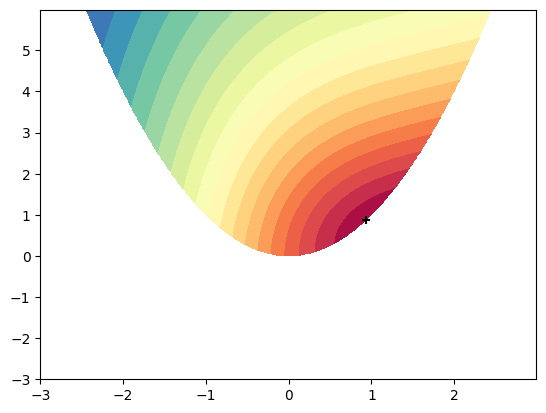

<Figure size 640x480 with 0 Axes>

In [15]:
verbo = True
plota_curvas_dom(f,[-3,3],[-2,6],alpha = 0.01)

Utilizando metodo: univariante
Metodo univariante atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 210
Ponto de minimo encontrado [0.93702181 0.87801347]
Tempo de execução: 3.10336971282959


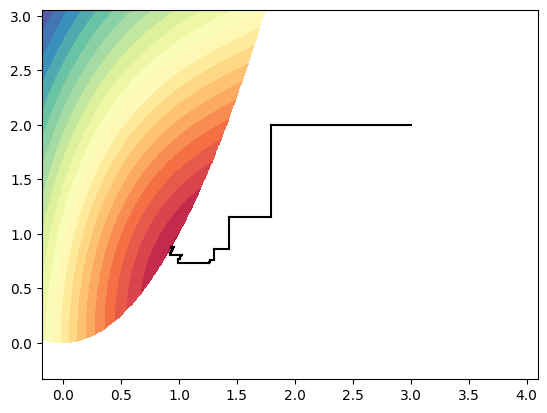

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 48
Ponto de minimo encontrado [0.94485909 0.89275951]
Tempo de execução: 1.0047504901885986


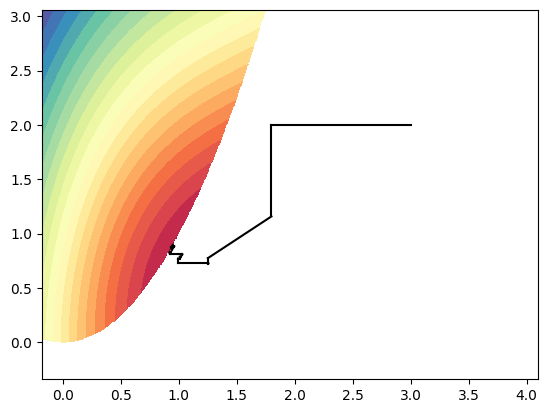

Utilizando metodo: steepest_descent
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 32
Ponto de minimo encontrado [0.94337924 0.88996566]
Tempo de execução: 0.8596847057342529


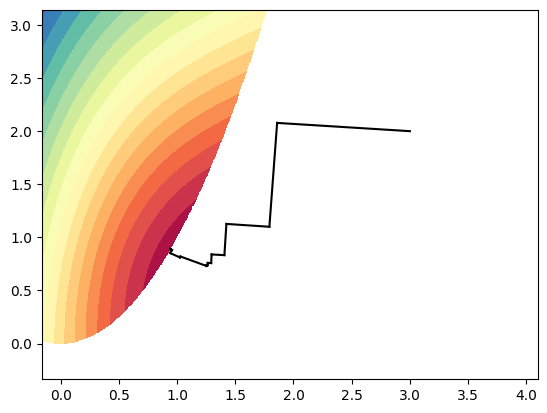

Utilizando metodo: fletcher_reeves
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 25
Ponto de minimo encontrado [0.94523483 0.89347099]
Tempo de execução: 0.7386610507965088


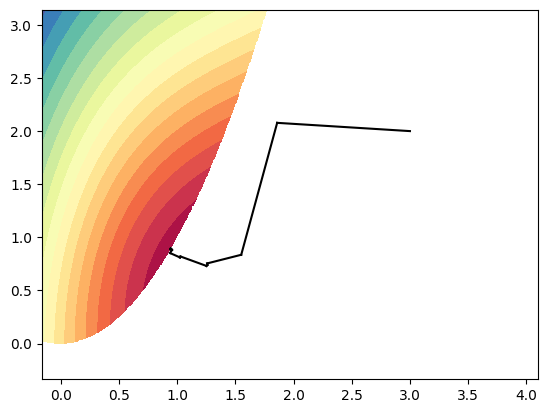

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 49
Ponto de minimo encontrado [0.96161525 0.92470459]
Tempo de execução: 1.2501814365386963


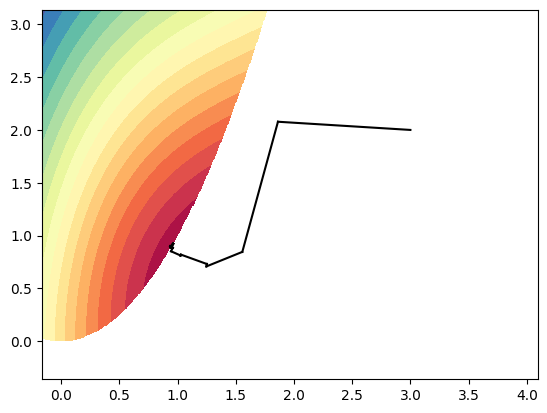

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 26
Ponto de minimo encontrado [0.94558303 0.89412691]
Tempo de execução: 0.6569709777832031


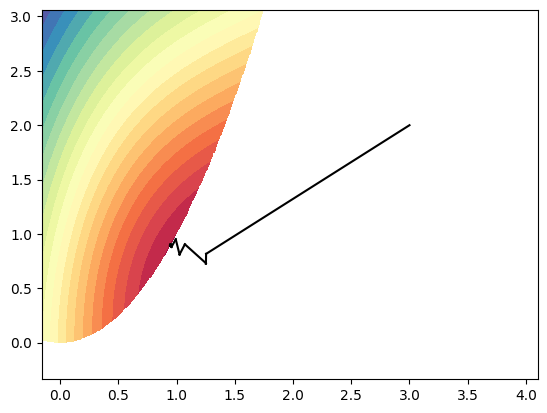

<Figure size 640x480 with 0 Axes>

In [16]:
tol_grad = 1e-5
tol_valor = 1e-5
tol_dist = 1e-5
tol_linear = 1e-5
tol_ocr = 1e-5
max_passos = 100
verbo = True

ponto = np.array([3.0,2.0])
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_penalidade(f,h,c,ponto,lista_metodos[i])



Utilizando metodo: univariante
Numero total de chamadas ao metodo OSR 10
Numero total de passos dos metodos OSR 170
Ponto de minimo encontrado [0.95115015 0.91143047]
Tempo de execução: 0.8195831775665283


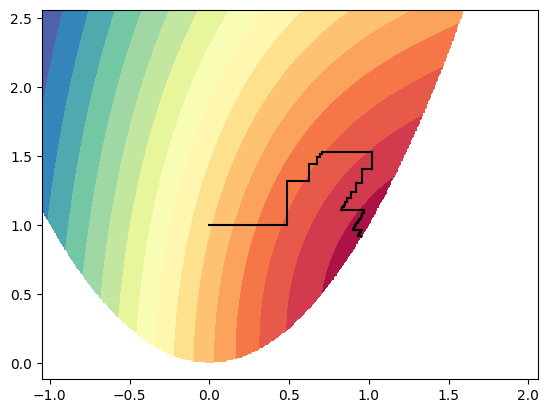

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 10
Numero total de passos dos metodos OSR 54
Ponto de minimo encontrado [0.94926454 0.90789831]
Tempo de execução: 0.3796079158782959


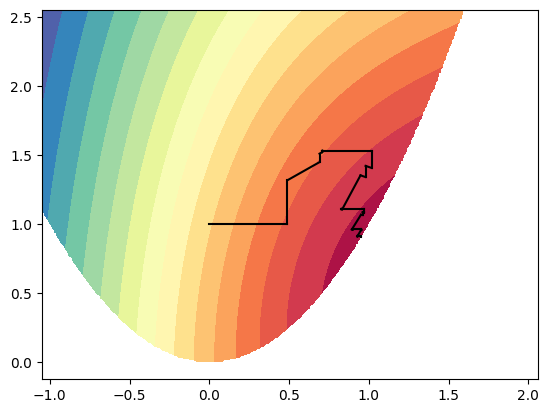

Utilizando metodo: steepest_descent
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 71
Ponto de minimo encontrado [0.94885315 0.91043446]
Tempo de execução: 0.528705358505249


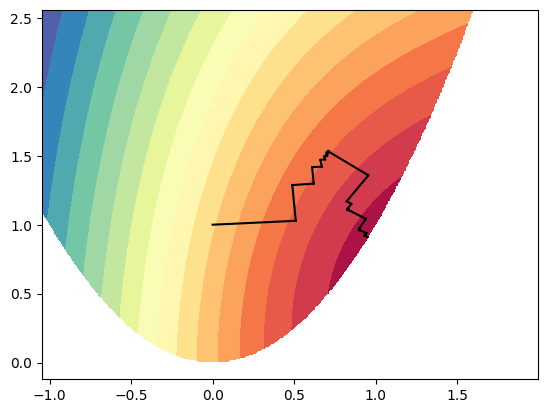

Utilizando metodo: fletcher_reeves
Numero total de chamadas ao metodo OSR 10
Numero total de passos dos metodos OSR 30
Ponto de minimo encontrado [0.94431243 0.90170894]
Tempo de execução: 0.26357197761535645


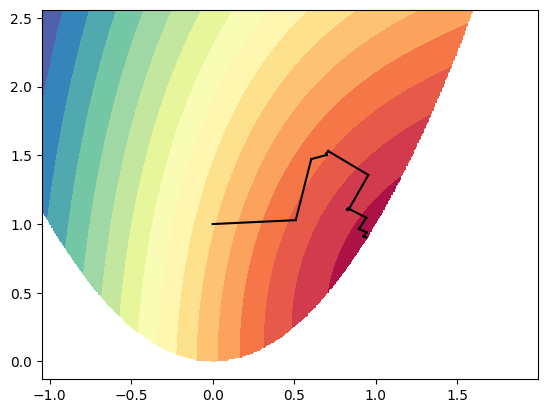

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 31
Ponto de minimo encontrado [0.9402781  0.90115305]
Tempo de execução: 0.22742891311645508


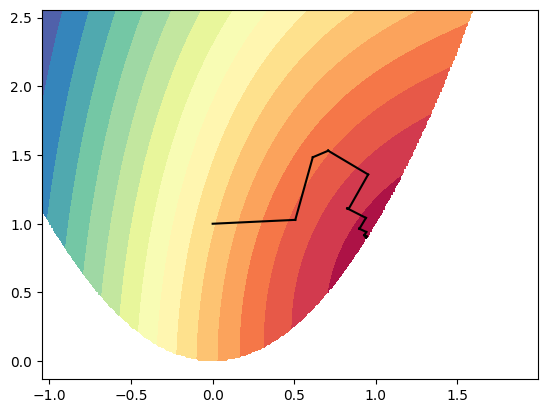

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 23
Ponto de minimo encontrado [0.94027784 0.901152  ]
Tempo de execução: 0.43434858322143555


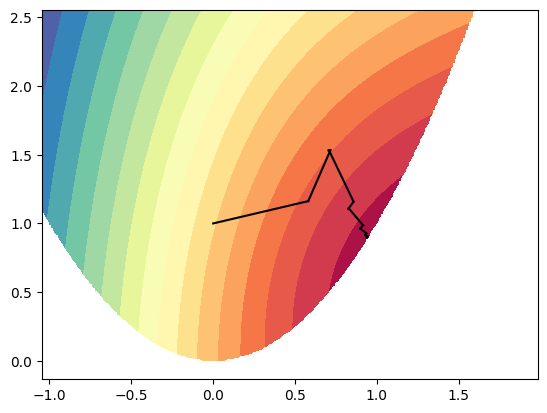

<Figure size 640x480 with 0 Axes>

In [17]:
tol_grad = 1e-5
tol_valor = 1e-5
tol_dist = 1e-5
tol_linear = 1e-5
tol_ocr = 1e-5
max_passos = 100

ponto = np.array([0.0,1.0])
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_barreira(f,h,c,ponto,lista_metodos[i])

## Problema 2

In [18]:
def h(x):
    #restricoes de igualdade
    return np.array([0])

def c(x):
    #restricoes de desigualde
    d = x[0]
    H = x[1]
    var1 = P*((H**2+B**2)**(1/2))/(pi*d*t*H)
    return np.array([var1 - sy, -d + 0.01, -10 + d, -H + 1, -100 + H,
                    var1 - ((pi**2)*(E/8)*(d**2+t**2))/(H**2+B**2)])

def f(x):
    d = x[0]
    H = x[1]
    return 2*rho*pi*d*t*(H**2+B**2)**(1/2)

rho = 0.3
pi = np.pi
t = 0.1
E = 3.0*10**7
P = 33.0*10**3
B = 30.0
sy = 10.0**5

(522, 88) 1.8800000000000008 20.21999999999989


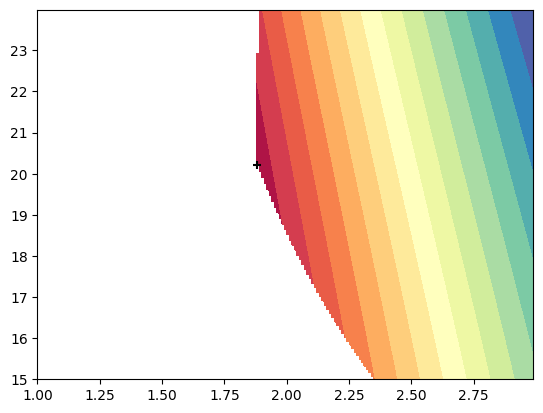

<Figure size 640x480 with 0 Axes>

In [19]:
verbo = True
plota_curvas_dom(f,[1,3],[16,24],alpha = 0.01)

Utilizando metodo: univariante
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 138
Ponto de minimo encontrado [ 1.87835751 20.23689339]
Tempo de execução: 1.1720452308654785


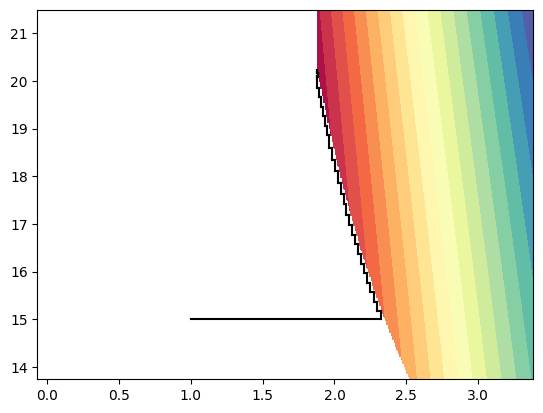

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 78
Ponto de minimo encontrado [ 1.87835706 20.23690069]
Tempo de execução: 0.6858043670654297


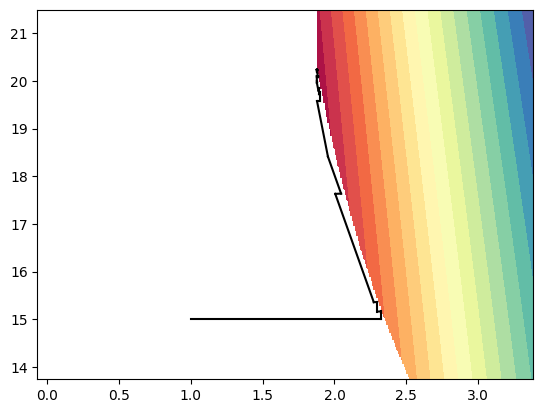

Utilizando metodo: steepest_descent
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 246
Ponto de minimo encontrado [ 1.87837932 20.23655762]
Tempo de execução: 3.2651453018188477


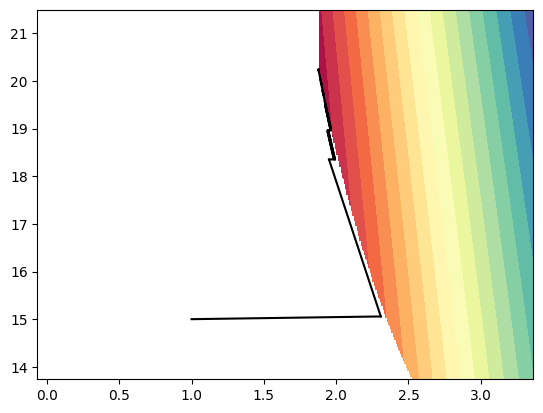

Utilizando metodo: fletcher_reeves
Numero total de chamadas ao metodo OSR 6
Numero total de passos dos metodos OSR 40
Ponto de minimo encontrado [ 1.8783484 20.2411425]
Tempo de execução: 0.5069024562835693


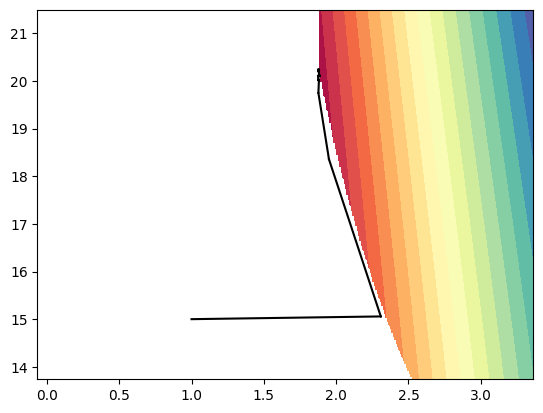

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 40
Ponto de minimo encontrado [ 1.87835798 20.23688621]
Tempo de execução: 0.4458780288696289


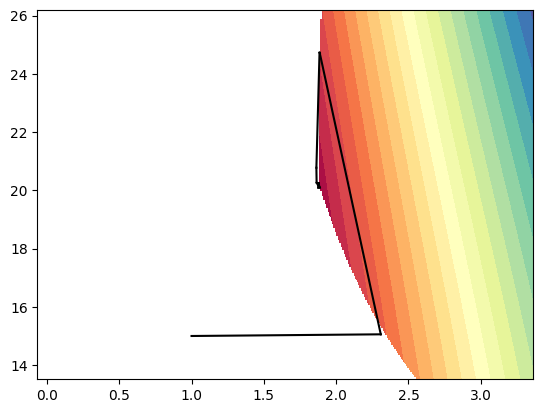

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 8
Numero total de passos dos metodos OSR 19
Ponto de minimo encontrado [ 1.87835658 20.23690845]
Tempo de execução: 0.5099163055419922


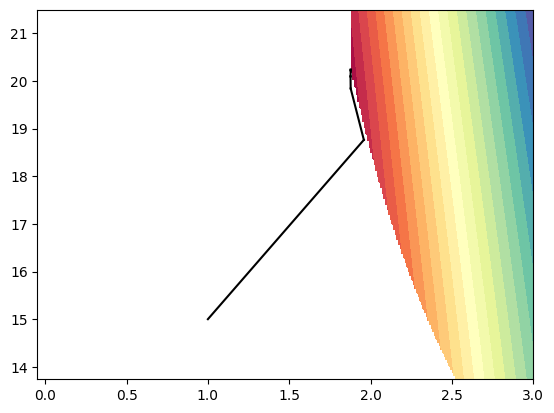

<Figure size 640x480 with 0 Axes>

In [20]:
tol_grad = 1e-6
tol_valor = 1e-6
tol_dist = 1e-6
tol_linear = 1e-6
tol_ocr = 1e-6
max_passos = 100
verbo = True

ponto = np.array([1.0,15.0])
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_penalidade(f,h,c,ponto,lista_metodos[i],rp = 10**(-7),beta_p = 10)

Utilizando metodo: univariante
Metodo univariante atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 142
Ponto de minimo encontrado [ 1.98531893 18.71008362]
Tempo de execução: 0.7751681804656982


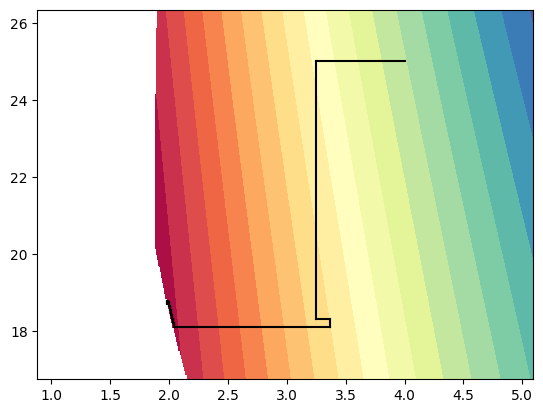

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 63
Ponto de minimo encontrado [ 1.91911911 19.6253998 ]
Tempo de execução: 0.41099071502685547


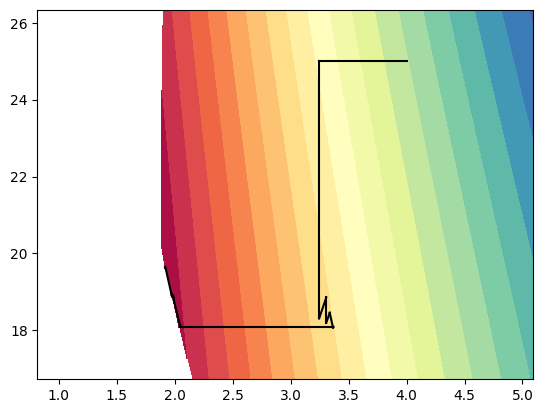

Utilizando metodo: steepest_descent
Steepest descent atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 147
Ponto de minimo encontrado [ 1.9764994  18.88247805]
Tempo de execução: 1.171741008758545


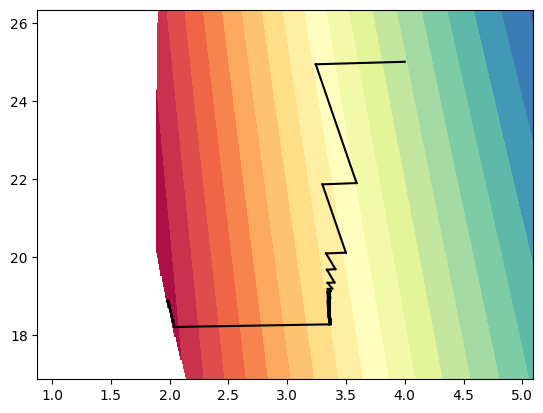

Utilizando metodo: fletcher_reeves
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 30
Ponto de minimo encontrado [ 1.97616721 18.88668764]
Tempo de execução: 0.3361480236053467


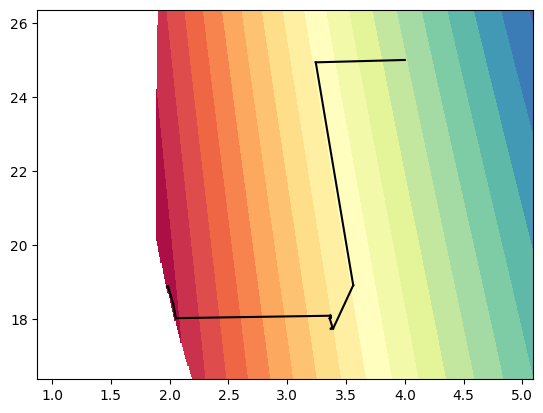

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 38
Ponto de minimo encontrado [ 1.88125246 20.27162466]
Tempo de execução: 0.3846011161804199


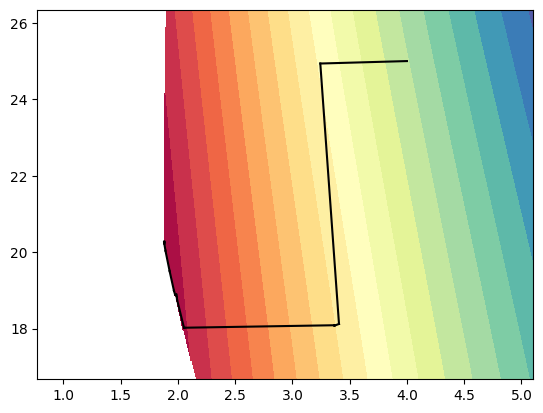

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 13
Numero total de passos dos metodos OSR 31
Ponto de minimo encontrado [ 1.87838848 20.24426348]
Tempo de execução: 0.9632809162139893


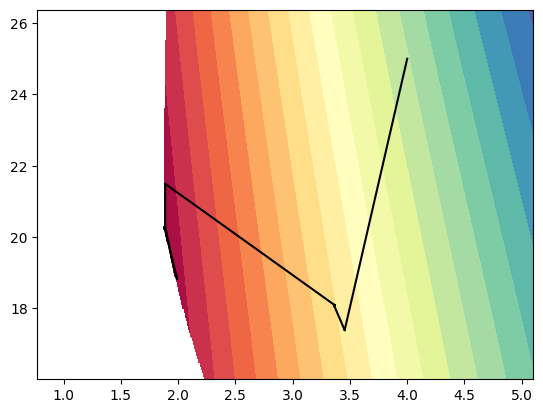

<Figure size 640x480 with 0 Axes>

In [21]:
tol_grad = 1e-6
tol_valor = 1e-6
tol_dist = 1e-6
tol_linear = 1e-6
tol_ocr = 1e-6
max_passos = 100
verbo = True

ponto = np.array([4.0,25.0])
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_barreira(f,h,c,ponto,lista_metodos[i],rb = 10**2,beta_b = 0.2)

## Problema 3

In [22]:
def h(x):
    #restricoes de igualdade
    return np.array([0])

def c(x):
    #restricoes de desigualde
    return np.array([100-(x[0]-5)**2-(x[1]-5)**2,
                    -82.81+(x[0]-6)**2+(x[1]-5)**2,
                    13-x[0],x[0]-100,
                    -x[1],x[1]-100])

def f(x):
    return (x[0]-10)**3 + (x[1] - 20)**3

(392, 213) 14.129999999999955 0.9199999999999164


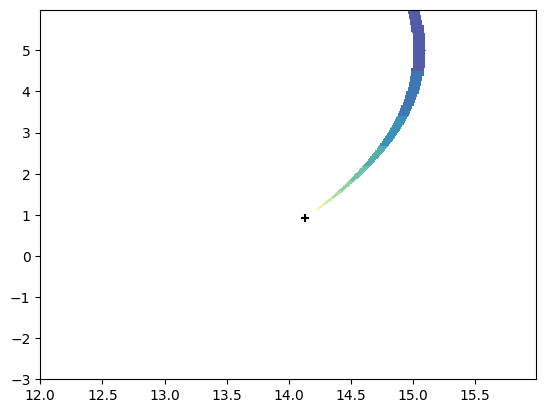

<Figure size 640x480 with 0 Axes>

In [23]:
verbo = True
plota_curvas_dom(f,[12,16],[-2,6],alpha = 0.01)

Utilizando metodo: univariante
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Met

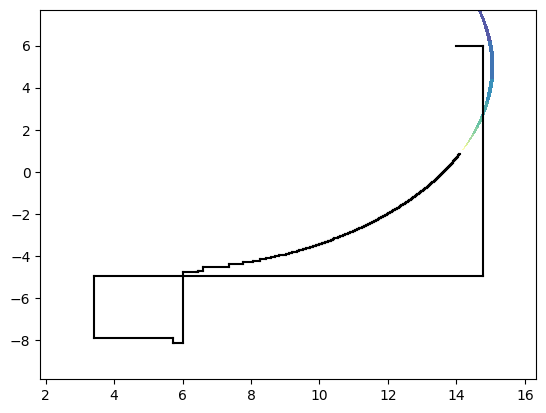

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 101
Numero total de passos dos metodos OSR 477
Ponto de minimo encontrado [14.09498856  0.8429372 ]
Tempo de execução: 3.1281261444091797


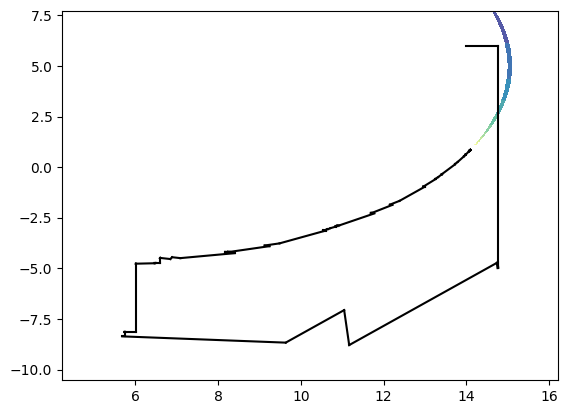

Utilizando metodo: steepest_descent
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 23
Numero total de passos dos metodos OSR 210

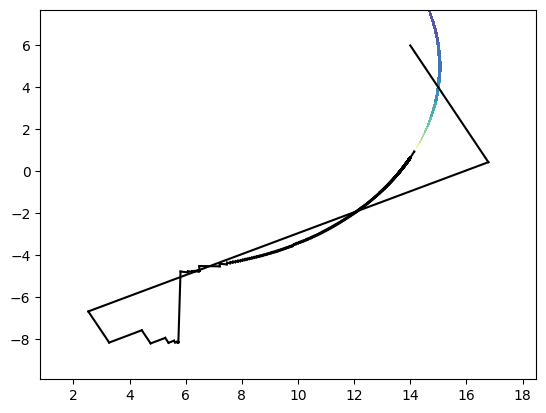

Utilizando metodo: fletcher_reeves
Fletcher-Reeves atingiu o máximo de passos
Fletcher-Reeves atingiu o máximo de passos
Fletcher-Reeves atingiu o máximo de passos
Fletcher-Reeves atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 101
Numero total de passos dos metodos OSR 605
Ponto de minimo encontrado [14.09499575  0.84295198]
Tempo de execução: 6.439420461654663


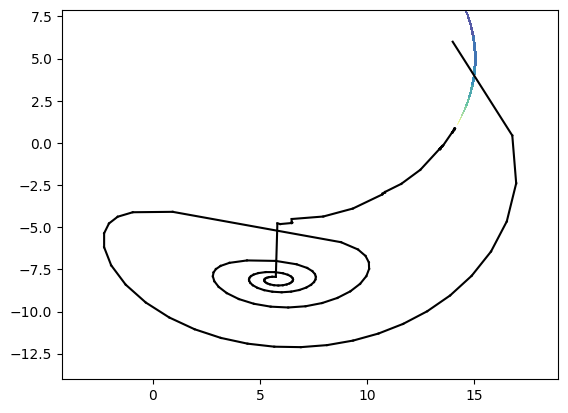

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 101
Numero total de passos dos metodos OSR 160
Ponto de minimo encontrado [14.09488367  0.84271946]
Tempo de execução: 1.6777231693267822


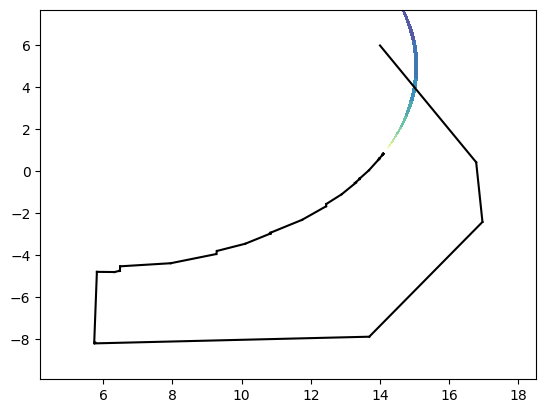

Utilizando metodo: newton_raphson
Newton-Raphson atingiu o máximo de passos
Newton-Raphson atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 12
Numero total de passos dos metodos OSR 251
Ponto de minimo encontrado [14.09500004  0.84296088]
Tempo de execução: 6.6613359451293945


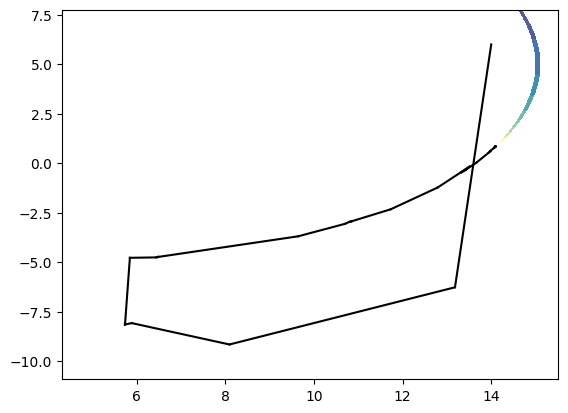

<Figure size 640x480 with 0 Axes>

In [24]:
tol_grad = 1e-6
tol_valor = 1e-6
tol_dist = 1e-6
tol_linear = 1e-6
tol_ocr = 1e-6
max_passos = 100
verbo = True

ponto = np.array([14.0,6.0])
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_penalidade(f,h,c,ponto,lista_metodos[i])

Utilizando metodo: univariante
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 76
Ponto de minimo encontrado [14.21        1.08100327]
Tempo de execução: 0.2735023498535156


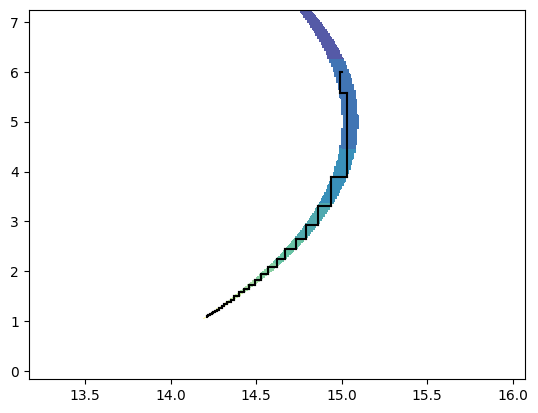

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 11
Numero total de passos dos metodos OSR 69
Ponto de minimo encontrado [14.09946113  0.85242783]
Tempo de execução: 0.24664926528930664


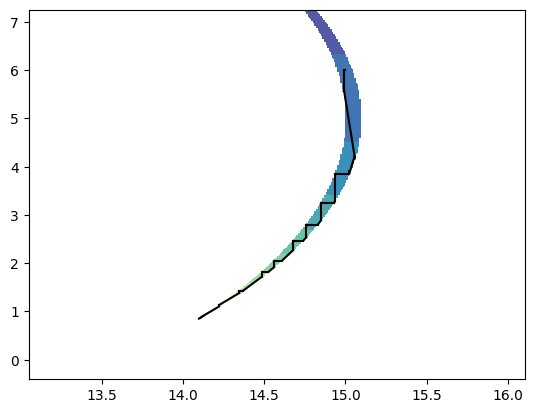

Utilizando metodo: steepest_descent
Steepest descent atingiu o máximo de passos
Steepest descent atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 2
Numero total de passos dos metodos OSR 202
Ponto de minimo encontrado [14.42379837  1.55766603]
Tempo de execução: 1.46488356590271


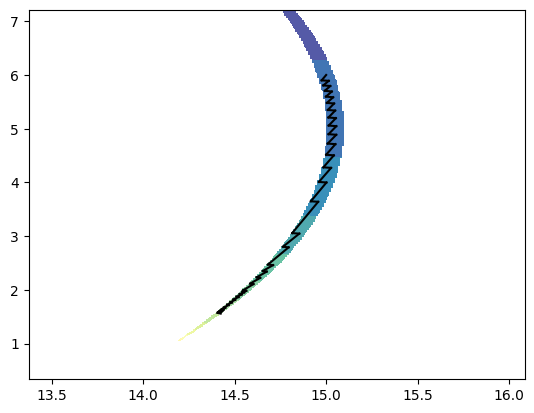

Utilizando metodo: fletcher_reeves
Fletcher-Reeves atingiu o máximo de passos
Fletcher-Reeves atingiu o máximo de passos
Fletcher-Reeves atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 314
Ponto de minimo encontrado [14.31408775  1.30203817]
Tempo de execução: 2.0669949054718018


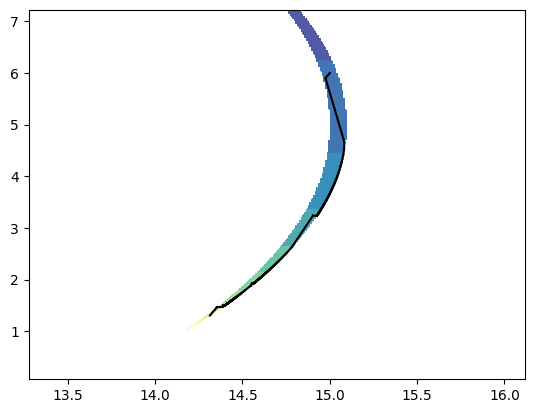

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 9
Numero total de passos dos metodos OSR 33
Ponto de minimo encontrado [14.12420237  0.9037868 ]
Tempo de execução: 0.29194068908691406


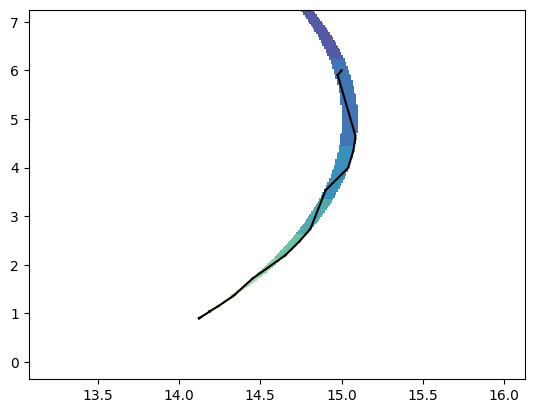

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 10
Numero total de passos dos metodos OSR 40
Ponto de minimo encontrado [14.09798039  0.84909349]
Tempo de execução: 0.7157142162322998


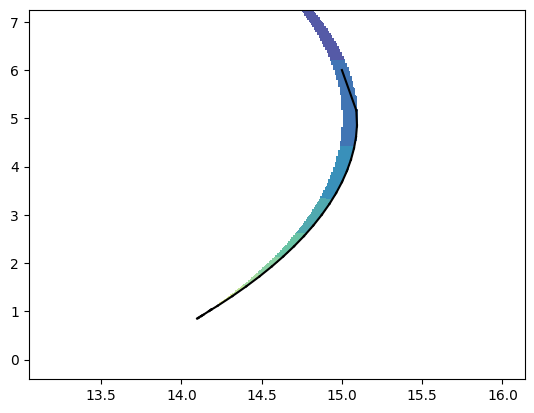

<Figure size 640x480 with 0 Axes>

In [25]:
tol_grad = 1e-5
tol_valor = 1e-5
tol_dist = 1e-5
tol_linear = 1e-5
tol_ocr = 1e-5
max_passos = 100
verbo = True

ponto = np.array([15.0,6.0])
alpha_linear = 0.01
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_barreira(f,h,c,ponto,lista_metodos[i], beta_b = 0.1)

## Problema 4

In [26]:
def sec(x):
    #numpy does not include native sec function
    #also, this converts the input from degrees to radians for np function
    x = np.deg2rad(x)
    return 1/np.cos(x)

def h(x):
    #restricoes de igualdade
    return np.array([0])

def c(x):
    #restricoes de desigualde
    R = x[0]/10.0
    t = x[1]/10.0

    e = 0.02*R
    A = 2*pi*R*t
    I = pi*t*R**3
    k = (I/A)**(1/2)
    c = R + t/2
    Pcr = pi**2*E*I/(4*L**2)

    var_s = P/A*(1+ (e*c/k**2)*sec((L/k)*(P/(E*A))**2))
    var_delta = e*(sec(L*(P/(E*I))**(1/2))-1)
    return np.array([var_delta - max_delta, var_s - sy,P - Pcr,
                     0.01 - R, R - 1, 0.005 - t, t - 0.2, R/t - 50])

def f(x):
    R = x[0]/10.0
    t = x[1]/10.0
    return rho*2*R*t*pi*L

pi = np.pi
P = 100*10**3
L = 5
E = 210*10**9
sy = 250*10**6
max_delta = 0.25
rho = 7850*10**3

<ipython-input-26-5de239590fcd>:19: RuntimeWarning: invalid value encountered in divide
  k = (I/A)**(1/2)
<ipython-input-26-5de239590fcd>:23: RuntimeWarning: divide by zero encountered in divide
  var_s = P/A*(1+ (e*c/k**2)*sec((L/k)*(P/(E*A))**2))
<ipython-input-26-5de239590fcd>:24: RuntimeWarning: divide by zero encountered in divide
  var_delta = e*(sec(L*(P/(E*I))**(1/2))-1)
<ipython-input-26-5de239590fcd>:24: RuntimeWarning: invalid value encountered in sqrt
  var_delta = e*(sec(L*(P/(E*I))**(1/2))-1)
/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in cos
  return f_raw(*args, **kwargs)


(105, 68) 0.68 0.05000000000000093


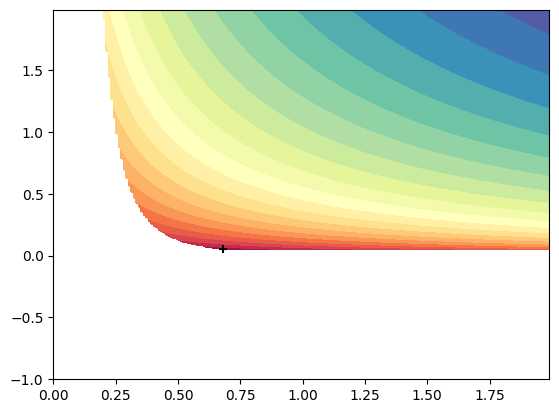

<Figure size 640x480 with 0 Axes>

In [27]:
verbo = True
plota_curvas_dom(f,[0,2],[0,2],alpha = 0.01)

Utilizando metodo: univariante
Metodo univariante atingiu o máximo de passos
Metodo univariante atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 27
Numero total de passos dos metodos OSR 262
Ponto de minimo encontrado [0.5124792  0.11410451]
Tempo de execução: 2.097325325012207


<ipython-input-26-5de239590fcd>:24: RuntimeWarning: invalid value encountered in sqrt
  var_delta = e*(sec(L*(P/(E*I))**(1/2))-1)


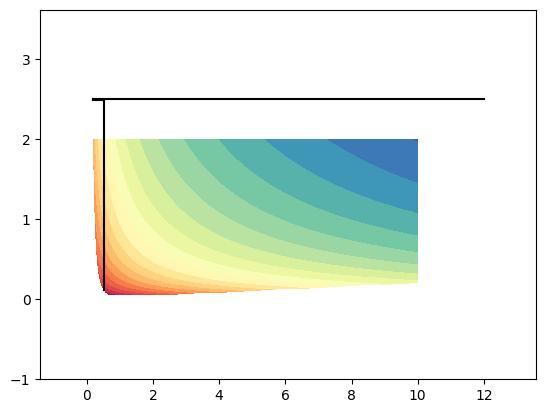

Utilizando metodo: powell
Metodo de powell atingiu o máximo de passos
Metodo de powell atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 4
Numero total de passos dos metodos OSR 210
Ponto de minimo encontrado [0.3685225  0.30685947]
Tempo de execução: 2.0172057151794434


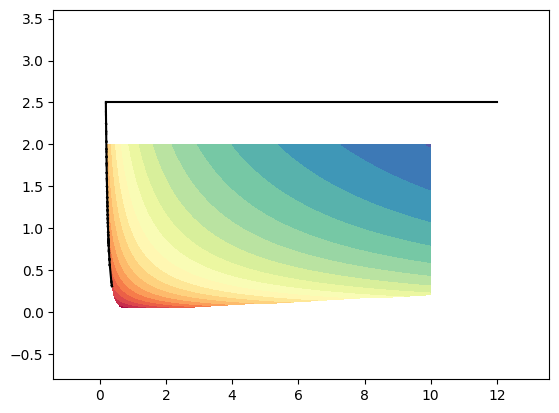

Utilizando metodo: steepest_descent


<ipython-input-26-5de239590fcd>:24: RuntimeWarning: invalid value encountered in scalar power
  var_delta = e*(sec(L*(P/(E*I))**(1/2))-1)


Steepest descent atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 15
Numero total de passos dos metodos OSR 194
Ponto de minimo encontrado [0.67458759 0.05002839]
Tempo de execução: 2.1810758113861084


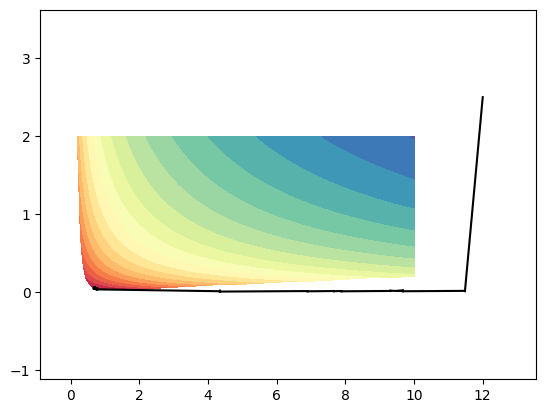

Utilizando metodo: fletcher_reeves
Fletcher-Reeves atingiu o máximo de passos
Numero total de chamadas ao metodo OSR 23
Numero total de passos dos metodos OSR 159
Ponto de minimo encontrado [0.6738471  0.05019381]
Tempo de execução: 1.8006134033203125


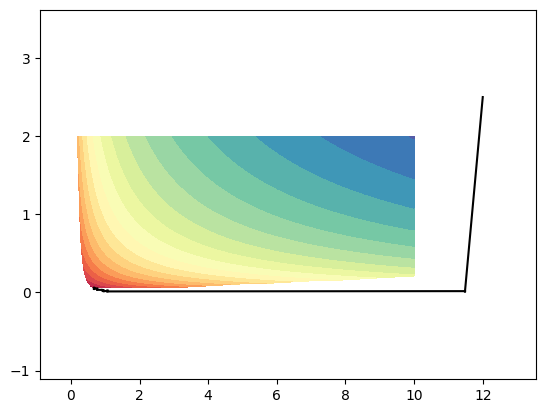

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 23
Numero total de passos dos metodos OSR 75
Ponto de minimo encontrado [0.63493176 0.05999989]
Tempo de execução: 1.0123648643493652


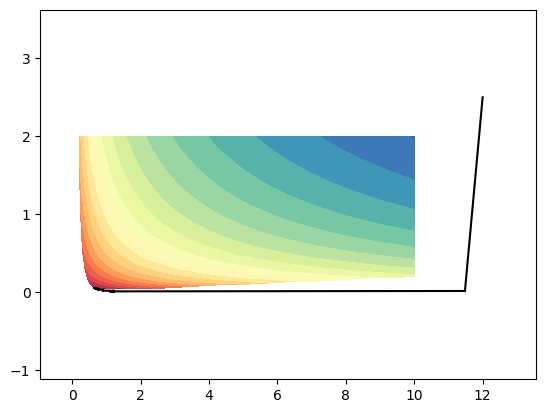

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 101
Numero total de passos dos metodos OSR 289
Ponto de minimo encontrado [0.93585665 0.01873713]
Tempo de execução: 11.900805711746216


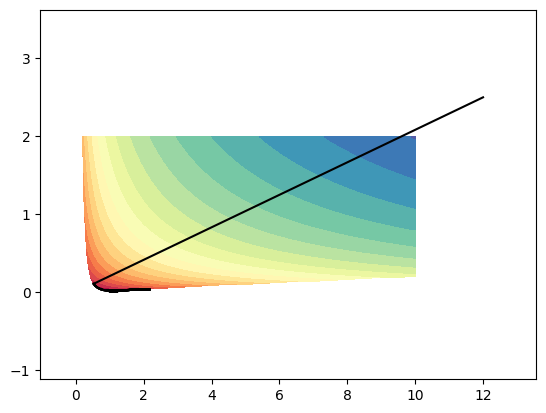

<Figure size 640x480 with 0 Axes>

In [28]:
tol_grad = 1e-6
tol_valor = 1e-6
tol_dist = 1e-6
tol_linear = 1e-6
tol_ocr = 1e-6
max_passos = 100
verbo = True

ponto = np.array([1.2,0.25])*10
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_penalidade(f,h,c,ponto,lista_metodos[i])

Utilizando metodo: univariante
Numero total de chamadas ao metodo OSR 15
Numero total de passos dos metodos OSR 76
Ponto de minimo encontrado [0.361012   0.32824355]
Tempo de execução: 0.5222816467285156


<ipython-input-26-5de239590fcd>:24: RuntimeWarning: invalid value encountered in sqrt
  var_delta = e*(sec(L*(P/(E*I))**(1/2))-1)


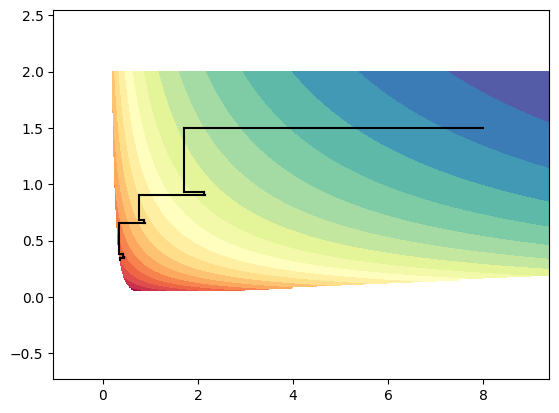

Utilizando metodo: powell
Numero total de chamadas ao metodo OSR 15
Numero total de passos dos metodos OSR 81
Ponto de minimo encontrado [0.36101206 0.3282432 ]
Tempo de execução: 0.619807243347168


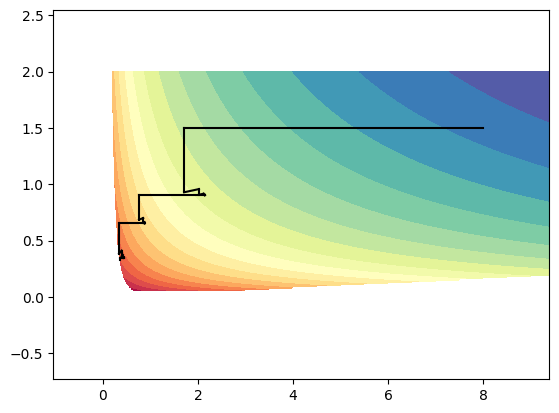

Utilizando metodo: steepest_descent
Numero total de chamadas ao metodo OSR 15
Numero total de passos dos metodos OSR 88
Ponto de minimo encontrado [0.38523657 0.27760983]
Tempo de execução: 0.971569299697876


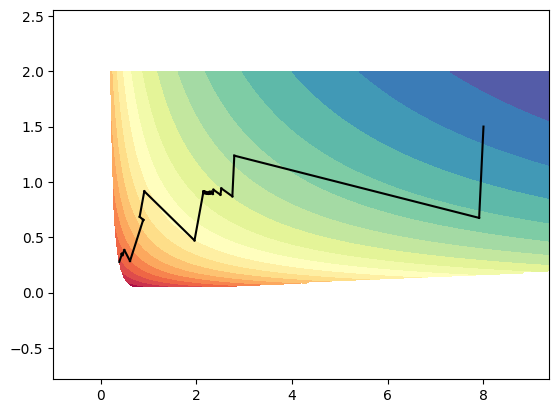

Utilizando metodo: fletcher_reeves
Numero total de chamadas ao metodo OSR 15
Numero total de passos dos metodos OSR 54
Ponto de minimo encontrado [0.38523651 0.27760967]
Tempo de execução: 1.0932588577270508


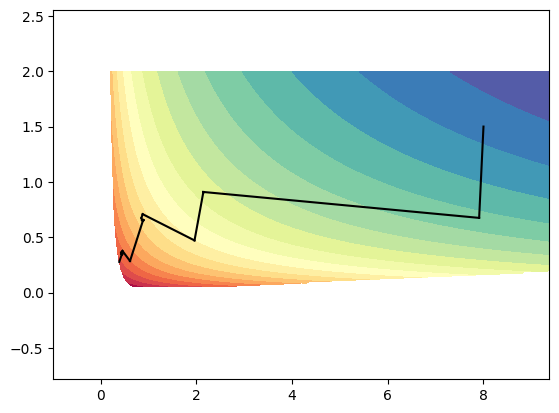

Utilizando metodo: bfgs
Numero total de chamadas ao metodo OSR 16
Numero total de passos dos metodos OSR 37
Ponto de minimo encontrado [0.42689652 0.20224231]
Tempo de execução: 0.7940623760223389


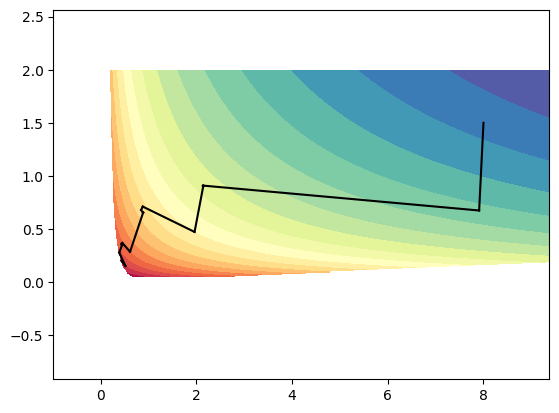

Utilizando metodo: newton_raphson
Numero total de chamadas ao metodo OSR 15
Numero total de passos dos metodos OSR 30
Ponto de minimo encontrado [0.37771083 0.29932549]
Tempo de execução: 1.165876865386963


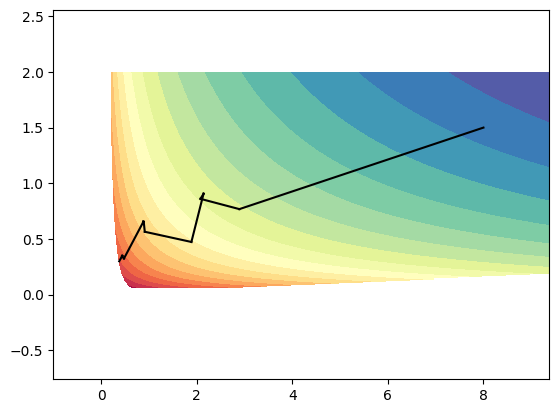

<Figure size 640x480 with 0 Axes>

In [29]:
tol_grad = 1e-6
tol_valor = 1e-6
tol_dist = 1e-6
tol_linear = 1e-6
tol_ocr = 1e-6
max_passos = 100
verbo = True

ponto = np.array([0.8,0.15])*10
for i in range(len(lista_metodos)):
    print("Utilizando metodo:",lista_metodos[i].__name__)
    ocr_barreira(f,h,c,ponto,lista_metodos[i], rb = 10**6, beta_b = 0.1)